In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
anime = pd.read_csv('anime.csv')
rating_full = pd.read_csv('rating.csv')

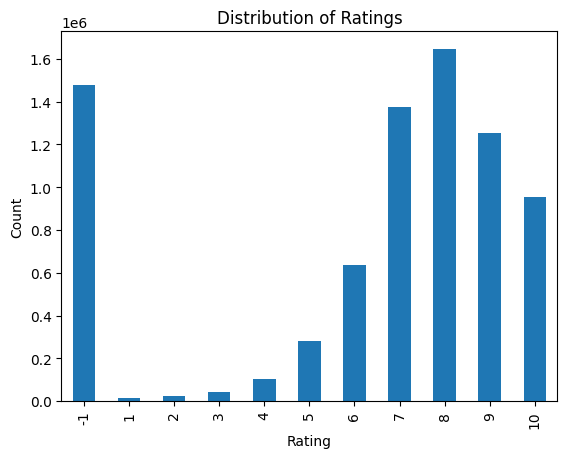

In [2]:
# Count the number of occurrences of each unique rating and sort by rating
rating_counts = rating_full['rating'].value_counts().sort_index()

# Create a bar chart of the rating counts with rotated x-tick labels
ax = rating_counts.plot(kind='bar')
ax.set_xticklabels(rating_counts.index, rotation=90)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.show()


In [3]:
# Clean and shorten the data
anime = anime.drop(columns=['members', 'episodes'])

'''
How to deal with the unrated one? remove | replace with 1e-6 (L2) | replace with mean value?
'''
# L2
rating_L2 = rating_full.replace(-1, 1e-6 )

# Remove
rating_drop_outliner = rating_full[rating_full['rating'] > -1]


# Replace -1 values with the mean rating using assign()
mean_rating = rating_full.loc[rating_full['rating'] >= 0, 'rating'].mean()
rating_replace_mean = rating_full.assign(rating=rating_full['rating'].replace(-1, mean_rating))

In [4]:
def plot_rating_counts(df, title):
    rating_counts = df['rating'].value_counts().sort_index()
    ax = rating_counts.plot(kind='bar')
    ax.set_xticklabels(rating_counts.index, rotation=90)
    plt.xlabel('Rating')
    plt.ylabel('Count')
    plt.title(title)
    plt.show()


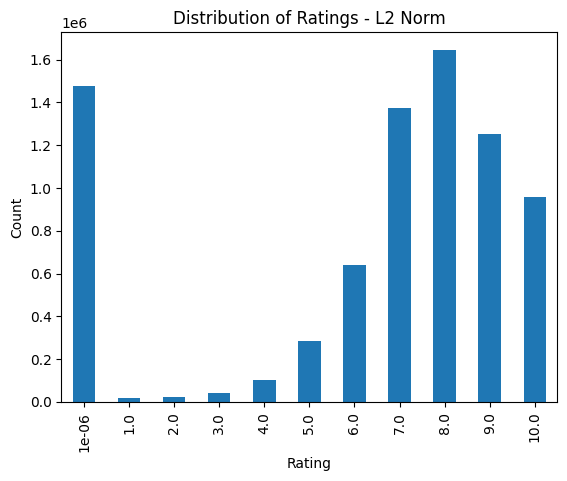

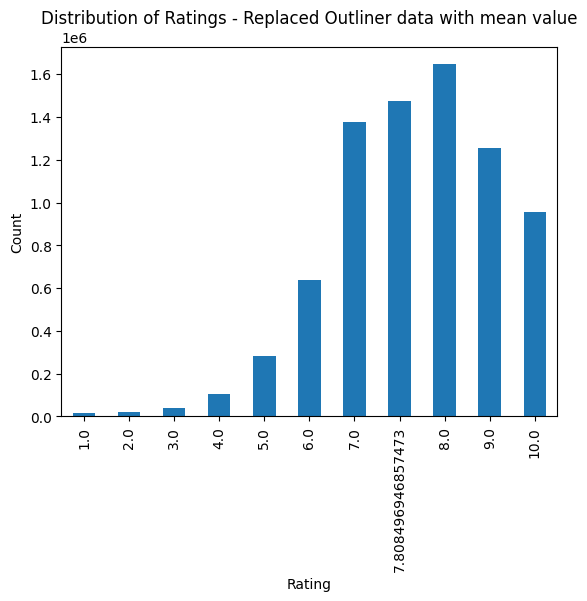

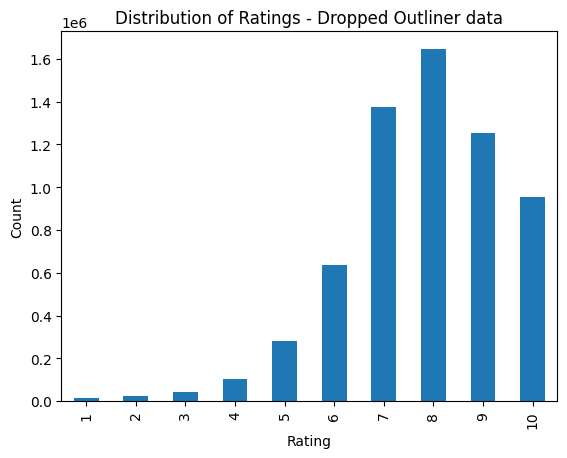

In [5]:
plot_rating_counts(rating_L2, 'Distribution of Ratings - L2 Norm')
plot_rating_counts(rating_replace_mean, 'Distribution of Ratings - Replaced Outliner data with mean value')
plot_rating_counts(rating_drop_outliner, 'Distribution of Ratings - Dropped Outliner data')


In [6]:
# Split the genre column into separate columns for each genre
anime_genres = anime['genre'].str.get_dummies(sep=',')
anime_genres = anime_genres.set_index(anime['anime_id'])
anime_genres

,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,Harem,...,Shoujo,Shounen,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi
anime_id,,,,,,,,,,,,,,,,,,,,,
32281,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5114,1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
28977,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9253,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9969,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9316,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5543,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5621,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
anime_id = 665
anime_genres.loc[anime_id][anime_genres.loc[anime_id] == 1].index

Index([' Drama', ' Fantasy', ' Horror', ' Shounen', ' Supernatural',
       ' Vampire', 'Adventure'],
      dtype='object')

In [8]:
anime[anime.anime_id == anime_id]

,anime_id,name,genre,type,rating
2581,665,JoJo no Kimyou na Bouken: Adventure,"Adventure, Drama, Fantasy, Horror, Shounen, Su...",OVA,7.22


In [9]:
# Create a utility matrix
def get_util_matrix(rating):
    return rating.pivot_table(values='rating', index='user_id', columns='anime_id')

In [16]:
def get_similar_items(user_id, rating, num_record=10):
    try:
        user_ratings = get_util_matrix(rating).loc[user_id].dropna()
    except:
        print('No user info in this dataset')
        return None
    # Exclude items that the user has already rated
    unrated_anime = anime_genres.loc[~anime_genres.index.isin(user_ratings.index)]
    # Calculate the user's genre preferences
    user_genre = anime_genres.loc[user_ratings.index].mean()
    # Calculate the cosine similarity between the user's genre preferences and unrated anime
    sim_scores = unrated_anime.dot(user_genre)
    sim_anime = sim_scores.nlargest(num_record).index
    rec_df = anime.loc[anime['anime_id'].isin(sim_anime)].copy()
    # Get the top similar anime
    rec_df['score'] = sim_scores.loc[sim_anime].values
    rec_df = rec_df.sort_values('score', ascending=False).head(num_record)
    print('Mean score: ', rec_df.score.mean())
    return rec_df


In [15]:
def user_info(user_id):
    top_watch = rating_full[rating_full.user_id == user_id].sort_values('rating',ascending = False)
    print('What they watched/voted:')
    display(top_watch)
    print('The items in the list are:')
    display(anime[anime.anime_id.isin(top_watch.anime_id.values)].sort_values('anime_id'))

In [12]:
def predict(user_id):
    print(f'Info of user {user_id} is:')
    user_info(user_id)
    print('-'*150)
    print('What we suggested (in case of using L2 norm for unvoted-data):')
    display(get_similar_items(user_id,rating_L2))
    print('-'*150)
    print('What we suggested (in case of dropping out unvoted-data):')
    display(get_similar_items(user_id,rating_drop_outliner))
    print('-'*150)
    print('What we suggested (in case of replacing unvoted-data with mean value):')
    display(get_similar_items(user_id,rating_replace_mean))


In [13]:
predict(1)

Info of user 1 is:
What they watched/voted:


,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
101,1,15451,10
83,1,11757,10
106,1,16706,-1
...,...,...,...
52,1,8841,-1
53,1,9041,-1
54,1,9062,-1
55,1,9136,-1


The items in the list are:


,anime_id,name,genre,type,rating
841,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,7.81
464,24,School Rumble,"Comedy, Romance, School, Shounen",TV,8.06
2281,79,Shuffle!,"Comedy, Drama, Ecchi, Fantasy, Harem, Magic, R...",TV,7.31
760,226,Elfen Lied,"Action, Drama, Horror, Psychological, Romance,...",TV,7.85
4551,241,Girls Bravo: First Season,"Comedy, Ecchi, Fantasy, Harem, Romance, School",TV,6.69
...,...,...,...,...,...
270,30015,ReLIFE,"Romance, School, Slice of Life",TV,8.24
900,30296,Rakudai Kishi no Cavalry,"Action, Ecchi, Fantasy, Romance, School",TV,7.78
2876,30544,Gakusen Toshi Asterisk,"Action, Comedy, Ecchi, Fantasy, Harem, Romance...",TV,7.14
5177,31338,Hundred,"Action, Ecchi, Harem, Mecha, Romance, School, ...",TV,6.53


------------------------------------------------------------------------------------------------------------------------------------------------------
What we suggested (in case of using L2 norm for unvoted-data):
Mean score:  3.161437908496732


,anime_id,name,genre,type,rating,score
1006,1840,Zero no Tsukaima: Futatsuki no Kishi,"Action, Adventure, Comedy, Ecchi, Fantasy, Har...",TV,7.73,3.431373
1246,1195,Zero no Tsukaima,"Action, Adventure, Comedy, Ecchi, Fantasy, Har...",TV,7.62,3.372549
1304,3712,Zero no Tsukaima: Princesses no Rondo,"Action, Adventure, Comedy, Ecchi, Fantasy, Har...",TV,7.60,3.248366
1480,28285,Trinity Seven OVA,"Action, Comedy, Ecchi, Fantasy, Harem, Magic, ...",OVA,7.53,3.196078
2228,31737,Gakusen Toshi Asterisk 2nd Season,"Comedy, Ecchi, Fantasy, Harem, Romance, School...",TV,7.32,3.143791
2992,157,Mahou Sensei Negima!,"Comedy, Ecchi, Fantasy, Harem, Magic, Romance,...",TV,7.11,3.104575
3283,6489,Zero no Tsukaima: Princesses no Rondo Picture ...,"Action, Adventure, Comedy, Drama, Ecchi, Fanta...",Special,7.04,3.045752
3842,30749,Saijaku Muhai no Bahamut,"Action, Ecchi, Fantasy, Harem, Mecha, Romance,...",TV,6.87,3.045752
4364,3503,Kanokon,"Comedy, Ecchi, Harem, Romance, School, Shounen...",TV,6.74,3.045752
11094,33581,Trinity Seven Movie: Eternity Library to Alche...,"Action, Comedy, Ecchi, Fantasy, Harem, Magic, ...",Movie,NaN,2.980392


------------------------------------------------------------------------------------------------------------------------------------------------------
What we suggested (in case of dropping out unvoted-data):
Mean score:  4.0


,anime_id,name,genre,type,rating,score
1006,1840,Zero no Tsukaima: Futatsuki no Kishi,"Action, Adventure, Comedy, Ecchi, Fantasy, Har...",TV,7.73,4.0
1036,24703,High School DxD BorN,"Action, Comedy, Demons, Ecchi, Harem, Romance,...",TV,7.71,4.0
1163,32215,High School DxD BorN: Yomigaeranai Fushichou,"Action, Comedy, Demons, Ecchi, Harem, Romance,...",OVA,7.66,4.0
1246,1195,Zero no Tsukaima,"Action, Adventure, Comedy, Ecchi, Fantasy, Har...",TV,7.62,4.0
1304,3712,Zero no Tsukaima: Princesses no Rondo,"Action, Adventure, Comedy, Ecchi, Fantasy, Har...",TV,7.60,4.0
1480,28285,Trinity Seven OVA,"Action, Comedy, Ecchi, Fantasy, Harem, Magic, ...",OVA,7.53,4.0
1845,25157,Trinity Seven,"Action, Comedy, Ecchi, Fantasy, Harem, Magic, ...",TV,7.43,4.0
2855,22877,Seirei Tsukai no Blade Dance,"Action, Comedy, Ecchi, Fantasy, Harem, Romance...",TV,7.15,4.0
2876,30544,Gakusen Toshi Asterisk,"Action, Comedy, Ecchi, Fantasy, Harem, Romance...",TV,7.14,4.0
3283,6489,Zero no Tsukaima: Princesses no Rondo Picture ...,"Action, Adventure, Comedy, Drama, Ecchi, Fanta...",Special,7.04,4.0


------------------------------------------------------------------------------------------------------------------------------------------------------
What we suggested (in case of replacing unvoted-data with mean value):
Mean score:  3.161437908496732


,anime_id,name,genre,type,rating,score
1006,1840,Zero no Tsukaima: Futatsuki no Kishi,"Action, Adventure, Comedy, Ecchi, Fantasy, Har...",TV,7.73,3.431373
1246,1195,Zero no Tsukaima,"Action, Adventure, Comedy, Ecchi, Fantasy, Har...",TV,7.62,3.372549
1304,3712,Zero no Tsukaima: Princesses no Rondo,"Action, Adventure, Comedy, Ecchi, Fantasy, Har...",TV,7.60,3.248366
1480,28285,Trinity Seven OVA,"Action, Comedy, Ecchi, Fantasy, Harem, Magic, ...",OVA,7.53,3.196078
2228,31737,Gakusen Toshi Asterisk 2nd Season,"Comedy, Ecchi, Fantasy, Harem, Romance, School...",TV,7.32,3.143791
2992,157,Mahou Sensei Negima!,"Comedy, Ecchi, Fantasy, Harem, Magic, Romance,...",TV,7.11,3.104575
3283,6489,Zero no Tsukaima: Princesses no Rondo Picture ...,"Action, Adventure, Comedy, Drama, Ecchi, Fanta...",Special,7.04,3.045752
3842,30749,Saijaku Muhai no Bahamut,"Action, Ecchi, Fantasy, Harem, Mecha, Romance,...",TV,6.87,3.045752
4364,3503,Kanokon,"Comedy, Ecchi, Harem, Romance, School, Shounen...",TV,6.74,3.045752
11094,33581,Trinity Seven Movie: Eternity Library to Alche...,"Action, Comedy, Ecchi, Fantasy, Harem, Magic, ...",Movie,NaN,2.980392


In [17]:
predict(493)

Info of user 493 is:
What they watched/voted:


,user_id,anime_id,rating
46466,493,223,-1
46467,493,232,-1
46468,493,250,-1
46469,493,392,-1
46470,493,481,-1
46471,493,527,-1
46472,493,552,-1
46473,493,1254,-1
46474,493,1313,-1
46475,493,1469,-1


The items in the list are:


,anime_id,name,genre,type,rating
346,223,Dragon Ball,"Adventure, Comedy, Fantasy, Martial Arts, Shou...",TV,8.16
322,232,Cardcaptor Sakura,"Adventure, Comedy, Drama, Fantasy, Magic, Roma...",TV,8.18
1141,250,Konjiki no Gash Bell!!,"Adventure, Comedy, Magic, Shounen, Supernatural",TV,7.66
120,392,Yuu☆Yuu☆Hakusho,"Action, Comedy, Demons, Fantasy, Martial Arts,...",TV,8.47
1371,481,Yu☆Gi☆Oh! Duel Monsters,"Adventure, Game, Shounen",TV,7.57
1834,527,Pokemon,"Action, Adventure, Comedy, Fantasy, Kids",TV,7.43
687,552,Digimon Adventure,"Action, Adventure, Comedy, Fantasy, Kids",TV,7.89
499,1254,Saint Seiya,"Adventure, Fantasy, Sci-Fi, Shounen",TV,8.03
2035,1313,Digimon Adventure 02,"Action, Adventure, Comedy, Drama, Fantasy, Kids",TV,7.37
3700,1469,Monster Farm: Enbanseki no Himitsu,"Action, Adventure, Comedy, Fantasy",TV,6.91


------------------------------------------------------------------------------------------------------------------------------------------------------
What we suggested (in case of using L2 norm for unvoted-data):
Mean score:  3.3


,anime_id,name,genre,type,rating,score
74,21,One Piece,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",TV,8.58,3.500000
173,6811,InuYasha: Kanketsu-hen,"Action, Adventure, Comedy, Demons, Fantasy, Ma...",TV,8.37,3.416667
200,121,Fullmetal Alchemist,"Action, Adventure, Comedy, Drama, Fantasy, Mag...",TV,8.33,3.416667
690,249,InuYasha,"Action, Adventure, Comedy, Demons, Fantasy, Ma...",TV,7.89,3.333333
1558,9135,Fullmetal Alchemist: The Sacred Star of Milos,"Action, Adventure, Comedy, Drama, Fantasy, Mag...",Movie,7.50,3.333333
1931,12231,Dragon Ball: Episode of Bardock,"Action, Adventure, Comedy, Fantasy, Martial Ar...",Special,7.40,3.250000
3408,22699,Dragon Ball Z: Zenbu Misemasu Toshi Wasure Dra...,"Action, Adventure, Comedy, Fantasy, Martial Ar...",Special,7.00,3.250000
4432,808,Bakuretsu Hunters OVA,"Action, Adventure, Comedy, Ecchi, Fantasy, Har...",OVA,6.72,3.166667
4444,225,Dragon Ball GT,"Action, Adventure, Comedy, Fantasy, Magic, Sci...",TV,6.72,3.166667
5917,231,Asagiri no Miko,"Action, Comedy, Drama, Fantasy, Magic, School,...",TV,6.31,3.166667


------------------------------------------------------------------------------------------------------------------------------------------------------
What we suggested (in case of dropping out unvoted-data):
No user info in this dataset


None

------------------------------------------------------------------------------------------------------------------------------------------------------
What we suggested (in case of replacing unvoted-data with mean value):
Mean score:  3.3


,anime_id,name,genre,type,rating,score
74,21,One Piece,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",TV,8.58,3.500000
173,6811,InuYasha: Kanketsu-hen,"Action, Adventure, Comedy, Demons, Fantasy, Ma...",TV,8.37,3.416667
200,121,Fullmetal Alchemist,"Action, Adventure, Comedy, Drama, Fantasy, Mag...",TV,8.33,3.416667
690,249,InuYasha,"Action, Adventure, Comedy, Demons, Fantasy, Ma...",TV,7.89,3.333333
1558,9135,Fullmetal Alchemist: The Sacred Star of Milos,"Action, Adventure, Comedy, Drama, Fantasy, Mag...",Movie,7.50,3.333333
1931,12231,Dragon Ball: Episode of Bardock,"Action, Adventure, Comedy, Fantasy, Martial Ar...",Special,7.40,3.250000
3408,22699,Dragon Ball Z: Zenbu Misemasu Toshi Wasure Dra...,"Action, Adventure, Comedy, Fantasy, Martial Ar...",Special,7.00,3.250000
4432,808,Bakuretsu Hunters OVA,"Action, Adventure, Comedy, Ecchi, Fantasy, Har...",OVA,6.72,3.166667
4444,225,Dragon Ball GT,"Action, Adventure, Comedy, Fantasy, Magic, Sci...",TV,6.72,3.166667
5917,231,Asagiri no Miko,"Action, Comedy, Drama, Fantasy, Magic, School,...",TV,6.31,3.166667


In [18]:
predict(511)

Info of user 511 is:
What they watched/voted:


,user_id,anime_id,rating
48440,511,1913,10
48412,511,1195,10
48358,511,339,10
48472,511,2904,10
48476,511,2993,10
...,...,...,...
48494,511,3656,1
48532,511,5178,1
48658,511,10075,-1
48325,511,66,-1


The items in the list are:


,anime_id,name,genre,type,rating
841,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,7.81
211,30,Neon Genesis Evangelion,"Action, Dementia, Drama, Mecha, Psychological,...",TV,8.32
151,33,Berserk,"Action, Adventure, Demons, Drama, Fantasy, Hor...",TV,8.40
1174,46,Rurouni Kenshin: Meiji Kenkaku Romantan - Ishi...,"Drama, Historical, Samurai, Shounen",Movie,7.65
1885,49,Aa! Megami-sama!,"Comedy, Magic, Romance, Seinen, Supernatural",OVA,7.41
...,...,...,...,...,...
1445,18393,Fairy Tail x Rave,"Action, Adventure, Comedy, Fantasy, Magic, Sho...",OVA,7.54
2403,18713,Haiyore! Nyaruko-san: Yasashii Teki no Shitome...,"Comedy, Parody, Sci-Fi",OVA,7.27
5512,18881,Code Geass: Hangyaku no Lelouch - Kiseki no Bi...,"School, Supernatural",Special,6.43
118,19815,No Game No Life,"Adventure, Comedy, Ecchi, Fantasy, Game, Super...",TV,8.47


------------------------------------------------------------------------------------------------------------------------------------------------------
What we suggested (in case of using L2 norm for unvoted-data):
Mean score:  1.9707373271889401


,anime_id,name,genre,type,rating,score
737,9790,Sora no Otoshimono: Tokeijikake no Angeloid,"Comedy, Drama, Ecchi, Harem, Romance, Sci-Fi, ...",Movie,7.87,2.158986
1215,2098,"Shin Kimagure Orange☆Road: Soshite, Ano Natsu ...","Comedy, Drama, Ecchi, Fantasy, Magic, Romance,...",Movie,7.63,2.076037
1480,28285,Trinity Seven OVA,"Action, Comedy, Ecchi, Fantasy, Harem, Magic, ...",OVA,7.53,2.071429
1845,25157,Trinity Seven,"Action, Comedy, Ecchi, Fantasy, Harem, Magic, ...",TV,7.43,1.949309
2228,31737,Gakusen Toshi Asterisk 2nd Season,"Comedy, Ecchi, Fantasy, Harem, Romance, School...",TV,7.32,1.942396
2621,1619,Negima!? Haru Special!?,"Comedy, Ecchi, Fantasy, Harem, Magic, Romance,...",OVA,7.21,1.933180
2845,29785,Jitsu wa Watashi wa,"Comedy, Fantasy, Romance, School, Shounen, Sup...",TV,7.15,1.917051
2876,30544,Gakusen Toshi Asterisk,"Action, Comedy, Ecchi, Fantasy, Harem, Romance...",TV,7.14,1.903226
4818,1836,Shuffle! Memories,"Comedy, Drama, Ecchi, Fantasy, Harem, Magic, R...",TV,6.63,1.891705
11094,33581,Trinity Seven Movie: Eternity Library to Alche...,"Action, Comedy, Ecchi, Fantasy, Harem, Magic, ...",Movie,NaN,1.864055


------------------------------------------------------------------------------------------------------------------------------------------------------
What we suggested (in case of dropping out unvoted-data):
Mean score:  1.9703016241299303


,anime_id,name,genre,type,rating,score
737,9790,Sora no Otoshimono: Tokeijikake no Angeloid,"Comedy, Drama, Ecchi, Harem, Romance, Sci-Fi, ...",Movie,7.87,2.157773
1215,2098,"Shin Kimagure Orange☆Road: Soshite, Ano Natsu ...","Comedy, Drama, Ecchi, Fantasy, Magic, Romance,...",Movie,7.63,2.076566
1480,28285,Trinity Seven OVA,"Action, Comedy, Ecchi, Fantasy, Harem, Magic, ...",OVA,7.53,2.071926
1845,25157,Trinity Seven,"Action, Comedy, Ecchi, Fantasy, Harem, Magic, ...",TV,7.43,1.951276
2228,31737,Gakusen Toshi Asterisk 2nd Season,"Comedy, Ecchi, Fantasy, Harem, Romance, School...",TV,7.32,1.941995
2621,1619,Negima!? Haru Special!?,"Comedy, Ecchi, Fantasy, Harem, Magic, Romance,...",OVA,7.21,1.932715
2845,29785,Jitsu wa Watashi wa,"Comedy, Fantasy, Romance, School, Shounen, Sup...",TV,7.15,1.914153
2876,30544,Gakusen Toshi Asterisk,"Action, Comedy, Ecchi, Fantasy, Harem, Romance...",TV,7.14,1.902552
4818,1836,Shuffle! Memories,"Comedy, Drama, Ecchi, Fantasy, Harem, Magic, R...",TV,6.63,1.890951
11094,33581,Trinity Seven Movie: Eternity Library to Alche...,"Action, Comedy, Ecchi, Fantasy, Harem, Magic, ...",Movie,NaN,1.863109


------------------------------------------------------------------------------------------------------------------------------------------------------
What we suggested (in case of replacing unvoted-data with mean value):
Mean score:  1.9707373271889401


,anime_id,name,genre,type,rating,score
737,9790,Sora no Otoshimono: Tokeijikake no Angeloid,"Comedy, Drama, Ecchi, Harem, Romance, Sci-Fi, ...",Movie,7.87,2.158986
1215,2098,"Shin Kimagure Orange☆Road: Soshite, Ano Natsu ...","Comedy, Drama, Ecchi, Fantasy, Magic, Romance,...",Movie,7.63,2.076037
1480,28285,Trinity Seven OVA,"Action, Comedy, Ecchi, Fantasy, Harem, Magic, ...",OVA,7.53,2.071429
1845,25157,Trinity Seven,"Action, Comedy, Ecchi, Fantasy, Harem, Magic, ...",TV,7.43,1.949309
2228,31737,Gakusen Toshi Asterisk 2nd Season,"Comedy, Ecchi, Fantasy, Harem, Romance, School...",TV,7.32,1.942396
2621,1619,Negima!? Haru Special!?,"Comedy, Ecchi, Fantasy, Harem, Magic, Romance,...",OVA,7.21,1.933180
2845,29785,Jitsu wa Watashi wa,"Comedy, Fantasy, Romance, School, Shounen, Sup...",TV,7.15,1.917051
2876,30544,Gakusen Toshi Asterisk,"Action, Comedy, Ecchi, Fantasy, Harem, Romance...",TV,7.14,1.903226
4818,1836,Shuffle! Memories,"Comedy, Drama, Ecchi, Fantasy, Harem, Magic, R...",TV,6.63,1.891705
11094,33581,Trinity Seven Movie: Eternity Library to Alche...,"Action, Comedy, Ecchi, Fantasy, Harem, Magic, ...",Movie,NaN,1.864055


In [19]:
predict(517)

Info of user 517 is:
What they watched/voted:


,user_id,anime_id,rating
49071,517,4224,10
49077,517,10620,9
49060,517,777,9
49062,517,889,9
49051,517,6,8
49078,517,11077,8
49055,517,73,8
49074,517,9253,8
49067,517,1686,8
49066,517,1575,8


The items in the list are:


,anime_id,name,genre,type,rating
214,6,Trigun,"Action, Comedy, Sci-Fi",TV,8.32
464,24,School Rumble,"Comedy, Romance, School, Shounen",TV,8.06
829,71,Full Metal Panic!,"Action, Comedy, Mecha, Military, Sci-Fi",TV,7.81
295,72,Full Metal Panic? Fumoffu,"Action, Comedy, School",TV,8.21
457,73,Full Metal Panic! The Second Raid,"Action, Mecha, Military",TV,8.06
846,150,Blood+,"Action, Drama, Horror, Military, Mystery, Supe...",TV,7.80
582,269,Bleach,"Action, Comedy, Shounen, Super Power, Supernat...",TV,7.95
1338,356,Fate/stay night,"Action, Fantasy, Magic, Romance, Supernatural",TV,7.58
2598,762,Bleach: Memories in the Rain,"Action, Adventure, Drama, Shounen, Supernatural",Special,7.21
66,777,Hellsing Ultimate,"Action, Horror, Military, Seinen, Supernatural...",OVA,8.59


------------------------------------------------------------------------------------------------------------------------------------------------------
What we suggested (in case of using L2 norm for unvoted-data):
Mean score:  2.4379310344827587


,anime_id,name,genre,type,rating,score
151,33,Berserk,"Action, Adventure, Demons, Drama, Fantasy, Hor...",TV,8.40,2.827586
173,6811,InuYasha: Kanketsu-hen,"Action, Adventure, Comedy, Demons, Fantasy, Ma...",TV,8.37,2.517241
690,249,InuYasha,"Action, Adventure, Comedy, Demons, Fantasy, Ma...",TV,7.89,2.413793
1845,25157,Trinity Seven,"Action, Comedy, Ecchi, Fantasy, Harem, Magic, ...",TV,7.43,2.413793
2554,1397,Macross 7,"Action, Adventure, Comedy, Drama, Mecha, Milit...",TV,7.23,2.413793
3288,11703,Code:Breaker,"Action, Comedy, School, Shounen, Super Power, ...",TV,7.03,2.379310
3680,15633,Code:Breaker OVA,"Action, Comedy, Ecchi, School, Shounen, Super ...",OVA,6.91,2.379310
4052,32379,Berserk (2016),"Action, Adventure, Demons, Drama, Fantasy, Hor...",TV,6.81,2.344828
5917,231,Asagiri no Miko,"Action, Comedy, Drama, Fantasy, Magic, School,...",TV,6.31,2.344828
6088,1224,Aquarian Age: Sign for Evolution,"Action, Adventure, Fantasy, Music, Romance, Sc...",TV,6.25,2.344828


------------------------------------------------------------------------------------------------------------------------------------------------------
What we suggested (in case of dropping out unvoted-data):
Mean score:  2.4379310344827587


,anime_id,name,genre,type,rating,score
151,33,Berserk,"Action, Adventure, Demons, Drama, Fantasy, Hor...",TV,8.40,2.827586
173,6811,InuYasha: Kanketsu-hen,"Action, Adventure, Comedy, Demons, Fantasy, Ma...",TV,8.37,2.517241
690,249,InuYasha,"Action, Adventure, Comedy, Demons, Fantasy, Ma...",TV,7.89,2.413793
1845,25157,Trinity Seven,"Action, Comedy, Ecchi, Fantasy, Harem, Magic, ...",TV,7.43,2.413793
2554,1397,Macross 7,"Action, Adventure, Comedy, Drama, Mecha, Milit...",TV,7.23,2.413793
3288,11703,Code:Breaker,"Action, Comedy, School, Shounen, Super Power, ...",TV,7.03,2.379310
3680,15633,Code:Breaker OVA,"Action, Comedy, Ecchi, School, Shounen, Super ...",OVA,6.91,2.379310
4052,32379,Berserk (2016),"Action, Adventure, Demons, Drama, Fantasy, Hor...",TV,6.81,2.344828
5917,231,Asagiri no Miko,"Action, Comedy, Drama, Fantasy, Magic, School,...",TV,6.31,2.344828
6088,1224,Aquarian Age: Sign for Evolution,"Action, Adventure, Fantasy, Music, Romance, Sc...",TV,6.25,2.344828


------------------------------------------------------------------------------------------------------------------------------------------------------
What we suggested (in case of replacing unvoted-data with mean value):
Mean score:  2.4379310344827587


,anime_id,name,genre,type,rating,score
151,33,Berserk,"Action, Adventure, Demons, Drama, Fantasy, Hor...",TV,8.40,2.827586
173,6811,InuYasha: Kanketsu-hen,"Action, Adventure, Comedy, Demons, Fantasy, Ma...",TV,8.37,2.517241
690,249,InuYasha,"Action, Adventure, Comedy, Demons, Fantasy, Ma...",TV,7.89,2.413793
1845,25157,Trinity Seven,"Action, Comedy, Ecchi, Fantasy, Harem, Magic, ...",TV,7.43,2.413793
2554,1397,Macross 7,"Action, Adventure, Comedy, Drama, Mecha, Milit...",TV,7.23,2.413793
3288,11703,Code:Breaker,"Action, Comedy, School, Shounen, Super Power, ...",TV,7.03,2.379310
3680,15633,Code:Breaker OVA,"Action, Comedy, Ecchi, School, Shounen, Super ...",OVA,6.91,2.379310
4052,32379,Berserk (2016),"Action, Adventure, Demons, Drama, Fantasy, Hor...",TV,6.81,2.344828
5917,231,Asagiri no Miko,"Action, Comedy, Drama, Fantasy, Magic, School,...",TV,6.31,2.344828
6088,1224,Aquarian Age: Sign for Evolution,"Action, Adventure, Fantasy, Music, Romance, Sc...",TV,6.25,2.344828
